# Figure 6

## Calling packages

In [1]:
####importing packages
import sys
sys.path.append('/work/mh0731/m300876/package')
import icons
from pathlib import Path
import importlib
import numpy as np
import xarray as xr
import intake
import dask
from distributed import Client, progress, wait
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

## Calling dask

In [2]:
icons.prepare_cpu(nworker=1,memory='256GB')

2023-12-06 14:55:23,922 - distributed.worker.memory - WARNING - Ignoring provided memory limit 256GB due to system memory limit of 235.37 GiB


Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.112.64/311464/1' processes=1 threads=256, memory=235.37 GiB>

## Setting functions

In [3]:
def read_file_top(files,times):
    ## This function extract the cloud top height data set
    ### file :  file of the data set
    ### times : [times_begin times_end] initial and last time of the analysis
    dataset = xr.open_mfdataset(files,
                        chunks={'time':1,'ncells':2621440*2}).sel(time=slice(times[0],times[1]))
    ## Masking data where cloud top height is lower than 0 masl
    dataset = dataset.where(dataset['cth']>0)
    return dataset

In [4]:
def read_file_base(files,times):
    ## This function extract the cloud base height data set
    ### file :  file of the data set
    ### times : [times_begin times_end] initial and last time of the analysis
    dataset = xr.open_mfdataset(files,
                        chunks={'time':1,'ncells':2621440*2}).sel(time=slice(times[0],times[1]))
    ## Masking data where cloud top height is higher than 99999 masl
    dataset = dataset.where(dataset['ctb']<99999)
    return dataset

In [5]:
def read_file_pp(files,times):
    ## This function extract precipitation data set
    ### file :  file of the data set
    ### times : [times_begin times_end] initial and last time of the analysis
    dataset = xr.open_mfdataset(files,
                        chunks={'time':1,'ncells':2621440*2}).sel(time=slice(times[0],times[1]))
    return dataset

In [6]:
def valid_cells(data,lat,lon,mask):
    ## This function select a region using latitude and longitude coordinates. A land-sea mask could be used.
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    ### mask : default None (no use of a land-sea mask); use 0 to mask land (remove), 1 to mask ocean (remove) 
    if mask is not None:
        valid = (((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])) & (data.land_sea_mask==mask)).values
    else:
        valid = (((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1]))).values
    return valid

In [7]:
def cloud_select(datarray,top_height):
    ## This function mask clouds based on the cloud top height (cth)
    ### top_height : [low_cth high_cth] 
    ## select clouds with cth between low_cth and high_cth
    return datarray.where((datarray>=top_height[0]) & (datarray<top_height[1]))

In [8]:
def area_clouds_pp(
    files_top,files_base,files_pp,times,
    top_height,range_pp,altitude_base=3000,lat=[-30,30],lon=[-180,180],mask=None):
    ## This function calculate the number of grid points between a range of precipitation and type of clouds
    ### files_top :  files conteining the cloud top height data 
    ### files_base :  files conteining the cloud base height data 
    ### files_pp :  files conteining precipitation data 
    ### times : [times_begin times_end] initial and last time of the analysis
    ### top_height : [low_cth high_cth] 
    ### altitude_base :  a base cloud height threshold
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    ### mask : default None (no use of a land-sea mask); use 0 to mask land (remove), 1 to mask ocean (remove) 

    ## Factor converting kg m s-1 to mm d-1
    factor = 1/24/3600
    ## Extract cloud top height, cloud base height data and precipitation data
    top_cloud = read_file_top(files_top,times)
    base_cloud = read_file_base(files_base,times)
    pr = read_file_pp(files_pp,times)

    ## identify grid points where clouds are over a certain location
    valid = valid_cells(top_cloud,lat,lon,mask=None)
    
    ## select clouds with cth between low_cth and high_cth
    topcloud_sel = cloud_select(top_cloud.cth,top_height) 
    
    ## Selecting clouds with a cloud base below 3km
    select_clouds = topcloud_sel.where(base_cloud.ctb<=altitude_base)
    
    ## Masking data where cloud top height is lower than 0 masl
    precip_select = pr.pr.where(select_clouds>0)
    
    ## Selecting clouds located over a especific region
    precip_valid = precip_select.isel(ncells=valid).compute()
    
    ## Compute the total number of grid points
    precip_cloud = (precip_valid.where(
        (precip_valid>=range_pp[0]*factor) & (precip_valid<range_pp[1]*factor))*0+1).sum('ncells')
    
   
    return precip_cloud

In [9]:
def mean_pp(files_pp,times,
    lat=[-30,30],lon=[-180,180],mask=None):
    ## This function compute the spatial average of tropica precipitation
    ### files_pp :  files conteining precipitation data 
    ### times : [times_begin times_end] initial and last time of the analysis
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    ### mask : default None (no use of a land-sea mask); use 0 to mask land (remove), 1 to mask ocean (remove) 
    
    ## Extracting precipitation data
    pr = read_file_pp(files_pp,times)
    
    ## Selecting grid points in a certain location
    valid = valid_cells(pr,lat,lon,mask)
    
    ## Compute the spatial average
    ppsel = pr.isel(ncells=valid).mean('ncells').compute()
    
    return ppsel.pr

In [14]:
def daily_area_tau(files_pp,times,tau,lat=[-30,30],lon=[-180,180],mask=None,factor=(1/3600/24)):
    ## This function cumpute the the number of grid points precipitating less than a threshold (tau)
    ### files_pp: files conteining precipitation data 
    ### times : [times_begin times_end] initial and last time of the analysis
    ### tau : precipitation threshold
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    
    ## Extracting precipitation data
    pr = read_file_pp(files_pp,times)
    
    ## Selecting grid points in a certain location
    valid = valid_cells(pr,lat,lon,mask)
    precip_valid = pr.pr.isel(ncells=valid).compute()
    
    ## Compute the daily number of grid points for the differente thresholds or tau
    if mask is None:
        mean_area = np.zeros((len(tau),int(pr.time.shape[0])))
        for t in range (len(tau)):
            if t < len(tau)-1:
                area=((precip_valid.where((
                    precip_valid>=tau[0]*factor) & (precip_valid<tau[t+1]*factor)))*0+1).sum(
                    dim=('ncells'))
            else:
                area=((precip_valid.where(
                    precip_valid>=tau[0]*factor))*0+1).sum(
                    dim=('ncells')).compute()
            mean_area[t,:] = area.values
    return mean_area

## Computing

### Generate files

In [11]:
## files of cloud top height
filetop = '/scratch/m/m300876/data/dpp0066/clouds/cloud_base_height/cloud_top_height_dpp0066_with_topo_20200201_202102028.nc'
## files of cloud base height
filebase = '/scratch/m/m300876/data/dpp0066/clouds/cloud_base_height/cloud_base_height_dpp0066_with_topo_20200201_202102028.nc'
## files of precipitation
filepp = '/scratch/m/m300876/data/dpp0066/clouds/cloud_base_height/pr_dpp0066_20200201_202102028.nc'
## times to analyze the data
times = ['2020-02-01','2021-01-31']

$[P](t)$

In [12]:
pp_mean = mean_pp(filepp,times,lat=[-30,30],lon=[-180,180],mask=None)

$[P]^\prime(t)$

In [13]:
pp_anom = pp_mean - pp_mean.mean()

$\tau$

In [15]:
limits_area = [0,1,20,70]

### Calculate the number of grid points for the differents tau

In [17]:
area_icon_tau = daily_area_tau(
    filepp,times,tau=limits_area,lat=[-30,30],lon=[-180,180],mask=None,factor=(1/3600/24))

In [18]:
area_icon_20_70 = area_icon_tau[2] - area_icon_tau[1]

### Calculate the number of grid points for differents tau and type of clouds

$\tau$

In [20]:
limits_pp = [20,70]

#### Calculate the number of grif points with congestus and precipitating between 20 and 70 mm d-1

Congestus: $\alpha_{20}^{70}(t)$

In [22]:
%time area_4_8_km_20_70_pp = area_clouds_pp(filetop,filebase,filepp,times,\
                                                        top_height=[4000,8000],range_pp=limits_pp)

CPU times: user 4min 58s, sys: 4min 26s, total: 9min 25s
Wall time: 6min 39s


#### Calculate the number of grif points with cumulonimbus and precipitating between 20 and 70 mm d-1

Cumolonimbus: $\alpha_{20}^{70}(t)$

In [27]:
%time area_8_15_km_20_70_pp = area_clouds_pp(filetop,filebase,filepp,times,\
                                                        top_height=[8000,15000],range_pp=limits_pp)

CPU times: user 4min 12s, sys: 4min 25s, total: 8min 37s
Wall time: 5min 35s


#### Calculating anomalies of $\alpha$

In [28]:
total_area_tropics = area_icon_tau[-1,0]

Congestus: $\alpha_{20}^{70}(t)^\prime$

In [30]:
anom_4_8 = area_4_8_km_20_70_pp.where(
    area_4_8_km_20_70_pp>0)/total_area_tropics -  (area_4_8_km_20_70_pp.where(area_4_8_km_20_70_pp>0)
                                                /total_area_tropics).mean()

Cumulonimbus: $\alpha_{20}^{70}(t)^\prime$

In [31]:
anom_8_15 = area_8_15_km_20_70_pp.where(
    area_8_15_km_20_70_pp>0)/total_area_tropics -  (area_8_15_km_20_70_pp.where(area_8_15_km_20_70_pp>0)
                                                 /total_area_tropics).mean()

$\alpha_{20}^{70}(t)^\prime$

In [33]:
anom_20_70 = area_icon_20_70/total_area_tropics - (area_icon_20_70/total_area_tropics).mean()
anom_20_70_new = anom_4_8.where(area_8_15_km_20_70_pp>0)*0+anom_20_70

## Plotting

### Figure 6

In [34]:
import seaborn as sns

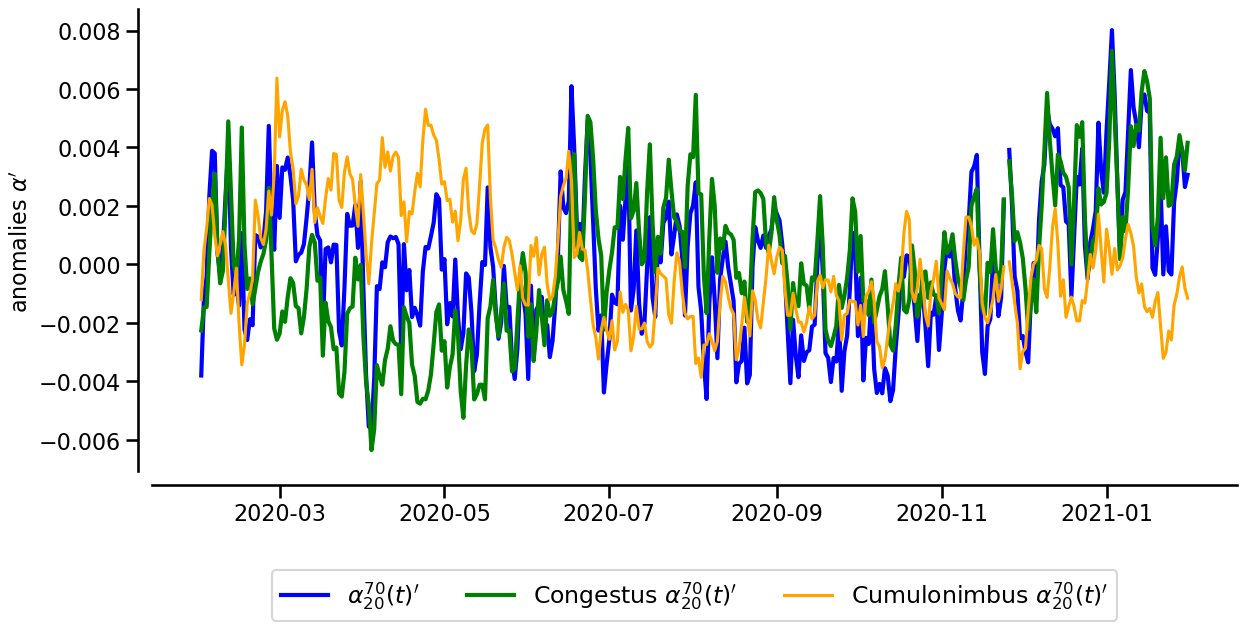

In [35]:
sns.set_context("talk")
fig = plt.figure(figsize=(14, 6),facecolor='white')
ax = fig.add_subplot(111)
lb1 = (anom_20_70_new).plot(color='b',linewidth=3,label=r"$\alpha^{70}_{20}(t)'$")
lb2 = (anom_4_8).plot(color='g',linewidth=3,label=r"Congestus $\alpha^{70}_{20}(t)'$")
lb3 = (anom_8_15).plot(color='orange',label=r"Cumulonimbus $\alpha^{70}_{20}(t)'$") 
ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel(r"anomalies $\alpha'$ ",fontsize=16)
ax.set_xlabel(None)
lns = lb1+lb2+lb3
labs = [l.get_label() for l in lns]
sns.despine(offset=10)
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.35),
          ncol=4, fancybox=True, shadow=False, fontsize=17)
plt.savefig(
    '/scratch/m/m300876/results/clouds/anomalies_area_icon_components_20_70_clouds.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

## Table 3

### Correlation

#### Including seasonal cycle

February 2020 to January 2021

r[$\alpha_{20}^{70}(t)^\prime,Congestus:\alpha_{20}^{70}(t)^\prime$]

In [41]:
rr_alpha_20_70_cth_4_8 =stats.pearsonr(anom_20_70_new.where(area_4_8_km_20_70_pp>0,drop=True),
              area_4_8_km_20_70_pp.where(area_4_8_km_20_70_pp>0,drop=True))[0]
print('r='+str(rr_alpha_20_70_cth_4_8))

r=0.6790362331363733


r[$\alpha_{20}^{70}(t)^\prime,Cumulonimbus:\alpha_{20}^{70}(t)^\prime$]

In [43]:
rr_alpha_20_70_cth_8_15 = stats.pearsonr(anom_20_70_new.where(area_8_15_km_20_70_pp>0,drop=True),
              area_8_15_km_20_70_pp.where(area_8_15_km_20_70_pp>0,drop=True))[0]
print('r='+str(rr_alpha_20_70_cth_8_15))

r=0.34094214532596767


June 2020 to January 2021

r[$\alpha_{20}^{70}(t)^\prime,Congestus:\alpha_{20}^{70}(t)^\prime$]

In [44]:
rr_alpha_20_70_cth_4_8_jun_all_year = stats.pearsonr(anom_20_70_new.where(area_8_15_km_20_70_pp>0,drop=True).sel(time=slice('2020-06-01','2021-01-31')),
              area_4_8_km_20_70_pp.where(area_4_8_km_20_70_pp>0,drop=True).sel(
    time=slice('2020-06-01','2021-01-31')))[0]
print('r='+str(rr_alpha_20_70_cth_4_8_jun_all_year))

r=0.8516690437461756


r[$\alpha_{20}^{70}(t)^\prime,Cumulonimbus:\alpha_{20}^{70}(t)^\prime$]

In [45]:
rr_alpha_20_70_cth_8_15_jun_all_year = stats.pearsonr(
    anom_20_70_new.where(area_8_15_km_20_70_pp>0,drop=True).sel(time=slice('2020-06-01','2021-01-31')),
              area_8_15_km_20_70_pp.where(area_8_15_km_20_70_pp>0,drop=True).sel(
    time=slice('2020-06-01','2021-01-31')))[0]
print('r='+str(rr_alpha_20_70_cth_8_15_jun_all_year))

r=0.5061384407567284


#### Removing seasonal cycle

$\alpha_{20}^{70}(t)^\prime$

In [46]:
anom_20_70_new_high = anom_20_70_new - anom_20_70_new.where(
    area_4_8_km_20_70_pp>0,drop=True).rolling(time=60,center=True).mean()

Congestus: $\alpha_{20}^{70}(t)^\prime$

In [47]:
area_4_8_km_20_70_pp_high = anom_4_8 - anom_4_8.where(
    area_4_8_km_20_70_pp>0,drop=True).rolling(time=60,center=True).mean()

Cumulonimbus: $\alpha_{20}^{70}(t)^\prime$

In [48]:
area_8_15_km_20_70_pp_high = anom_8_15 - anom_8_15.where(
    area_8_15_km_20_70_pp>0,drop=True).rolling(time=60,center=True).mean()

February 2020 to January 2021

r[$\alpha_{20}^{70}(t)^\prime,Congestus:\alpha_{20}^{70}(t)^\prime$]

In [49]:
rr_alpha_20_70_cth_4_8_high = stats.pearsonr(area_4_8_km_20_70_pp_high[30:-29],anom_20_70_new_high[30:-29])[0]
print('r='+str(rr_alpha_20_70_cth_4_8_high))

r=0.7569914402862722


r[$\alpha_{20}^{70}(t)^\prime,Cumulonimbus:\alpha_{20}^{70}(t)^\prime$]

In [50]:
rr_alpha_20_70_cth_8_15_high = stats.pearsonr(area_8_15_km_20_70_pp_high[30:-29],anom_20_70_new_high[30:-29])[0]
print('r='+str(rr_alpha_20_70_cth_8_15_high))

r=0.6545838650549953


June 2020 to January 2021

r[$\alpha_{20}^{70}(t)^\prime,Congestus:\alpha_{20}^{70}(t)^\prime$]

In [51]:
rr_alpha_20_70_cth_4_8_jun_all_year_high = stats.pearsonr(area_4_8_km_20_70_pp_high.sel(time=slice('2020-06-01','2020-12-31')),
               anom_20_70_new_high.sel(time=slice('2020-06-01','2020-12-31')))[0]
print('r='+str(rr_alpha_20_70_cth_4_8_jun_all_year_high))

r=0.7981176815324668


r[$\alpha_{20}^{70}(t)^\prime,Cumulonimbus:\alpha_{20}^{70}(t)^\prime$]

In [52]:
rr_alpha_20_70_cth_8_15_jun_all_year_high = stats.pearsonr(area_8_15_km_20_70_pp_high.sel(time=slice('2020-06-01','2020-12-31')),
               anom_20_70_new_high.sel(time=slice('2020-06-01','2020-12-31')))[0]
print('r='+str(rr_alpha_20_70_cth_8_15_jun_all_year_high))

r=0.6416935135586019
